# From start to finish
Generate a movie of the projections and reconstructions from a selected sample

In [1]:
import matplotlib.pylab as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import glob
import os
import dask
import dask_image.imread
import math
import skimage
import numpy
# import skimage.transform
# from tqdm import tqdm_notebook
# import time
from IPython import display

In [2]:
# Load our own log file parsing code
from BrukerSkyScanLogfileRuminator.parsing_functions import *

In [3]:
# Display and output defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation

In [4]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = '#E6002E'  # unibe red as default scalebar color

In [5]:
seaborn.set_context('talk')

The original scans are in the archive at `DKF Lung-Metastasis\Overview\
Get the files to the FastSSD with 
````
rsync --verbose --recursive --compress --times --update --omit-dir-times --prune-empty-dirs --include="*/" --include="*.?og" --include="*.c?v" --include="*.?if" --include="*.png" --exclude="*" ~/research-storage-uct/Archiv_Tape/DKF\ Lung-Metastasis/Overview/KP-TNIKWT02/ /media/habi/Fast_SSD/DKF\ Lung-Metastasis/Overview/KP-TNIKWT02/
````
If the PNGs in the `rec` folder are no longer there, you'll need to reconstruct them again :)

In [6]:
fastSSD = True
if fastSSD:
    Root = '/media/habi/Fast_SSD/'
else:
    Root = '/home/habi/1272/'
BaseFolder = os.path.join(Root, 'DKF Lung-Metastasis', 'Overview')
Sample = 'KP-TNIKWT02'

In [7]:
print(BaseFolder)

/media/habi/Fast_SSD/DKF Lung-Metastasis/Overview


In [8]:
os.path.join(BaseFolder, Sample, 'proj', '*.log')

'/media/habi/Fast_SSD/DKF Lung-Metastasis/Overview/KP-TNIKWT02/proj/*.log'

In [9]:
os.path.join(BaseFolder, Sample, 'proj', Sample + '0*.tif')

'/media/habi/Fast_SSD/DKF Lung-Metastasis/Overview/KP-TNIKWT02/proj/KP-TNIKWT020*.tif'

In [10]:
# Get file names
Logfile = sorted(glob.glob(os.path.join(BaseFolder, Sample, 'proj', '*.log')))[0]
Projections = dask_image.imread.imread(os.path.join(BaseFolder, Sample, 'proj', '*[0.123456789].tif'))  # Exclude `KP-TNIKWT2_arc.tif`
Reconstructions = dask_image.imread.imread(os.path.join(BaseFolder, Sample, 'rec', '*.png'))

In [11]:
# Dicard some of the lower reconstructions, which only contain the sample holder and light up if we present them with equalized histogram
Reconstructions = Reconstructions[215:]

In [12]:
Projections

dask.array<_map_read_frame, shape=(940, 820, 1224), dtype=uint16, chunksize=(1, 820, 1224), chunktype=numpy.ndarray>

In [13]:
Reconstructions

dask.array<getitem, shape=(552, 916, 916, 3), dtype=uint8, chunksize=(1, 916, 916, 3), chunktype=numpy.ndarray>

In [14]:
if not Logfile:
    print('Please mount the fast SSD...')

In [15]:
Pixelsize = pixelsize(Logfile)
print('We scanned the sample with a voxel size of %0.2f um' % Pixelsize)

We scanned the sample with a voxel size of 21.61 um


In [16]:
# Details of the output movie
Seconds = 15
NumberOfFrames = 24 * Seconds # show animation for $Seconds seconds with a frame rate of 24 fps
WidthOfOutput = 800

In [17]:
print('We have %s projections' % (len(Projections)))
print('and %s reconstructions' % (len(Reconstructions)))

We have 940 projections
and 552 reconstructions


In [18]:
# Select exactly this many evenly spaced elements from array
# https://stackoverflow.com/a/50685454/323100
# idx = numpy.round(numpy.linspace(0, len(Projections) - 1, NumberOfFrames)).astype(int)

In [19]:
print('Of these projections and reconstructions I will work with approximately %s equally spaced images' % NumberOfFrames)

Of these projections and reconstructions I will work with approximately 360 equally spaced images


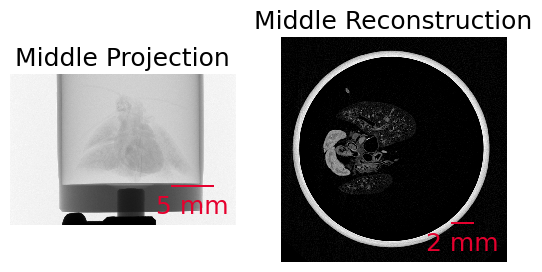

In [33]:
# Show middle images
plt.subplot(121)
plt.imshow(Projections[Projections.shape[0] // 2])
plt.gca().add_artist(ScaleBar(Pixelsize, 'um'))
plt.title('Middle Projection')
plt.axis('off')
plt.subplot(122)
plt.imshow(Reconstructions[Reconstructions.shape[0] // 2])
plt.gca().add_artist(ScaleBar(Pixelsize, 'um'))
plt.title('Middle Reconstruction')
plt.axis('off')
plt.show()

In [21]:
# Make output directories
os.makedirs(os.path.join(BaseFolder, Sample, 'mov', 'mov_proj'), exist_ok=True)
os.makedirs(os.path.join(BaseFolder, Sample, 'mov', 'mov_rec'), exist_ok=True)

Write out single frames *with* a scale bar of fixed length (5 mm for example).

In [22]:
# Delete files from previous runs
# Based on https://stackoverflow.com/a/37994379/323100
for file in os.scandir(os.path.join(BaseFolder,
                                    Sample,
                                    'mov',
                                    'mov_proj')):
    os.remove(file.path)
for file in os.scandir(os.path.join(BaseFolder,
                                    Sample,
                                    'mov',
                                    'mov_rec')):
    os.remove(file.path)

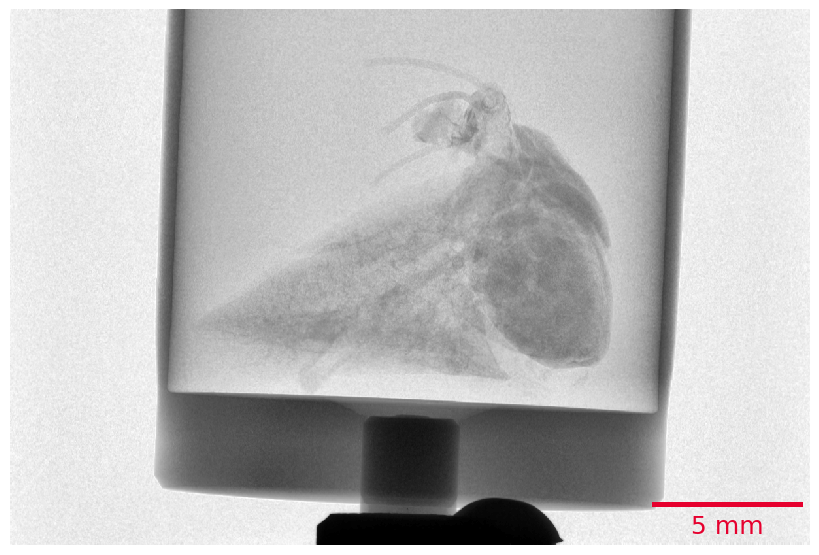

Done


In [23]:
# Let's write the output image with the chosen width (and scaled height)
# Scale the output figure size exactly: https://stackoverflow.com/a/13714720/323100
# Write canvas containts to image: https://stackoverflow.com/a/14913405/323100
for c, projection in enumerate(Projections[numpy.round(numpy.linspace(0, len(Projections) - 1, NumberOfFrames)).astype(int)]):
    # Generate a figure with the chosen width and accordingly scaled height
    fig = plt.figure(figsize=(WidthOfOutput / plt.rcParams['figure.dpi'],
                              round(WidthOfOutput * (projection.shape[0] / projection.shape[1])) / plt.rcParams['figure.dpi']),
                     dpi=plt.rcParams['figure.dpi'])
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    # Equalize histogram for display reasons
    ax.imshow(skimage.exposure.equalize_adapthist(projection))
    ax.add_artist(ScaleBar(Pixelsize, 'um', fixed_value=5, fixed_units='mm'))
    s = '_'
    fig.canvas.print_jpg(os.path.join(BaseFolder, Sample, 'mov', 'mov_proj',
                                      s.join([Sample,
                                              str(NumberOfFrames),
                                              'projections',
                                              'of',
                                              str(len(Projections)),
                                              str(WidthOfOutput),
                                              'px',
                                              '%03d.jpg' % c])))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.show()
print('Done')



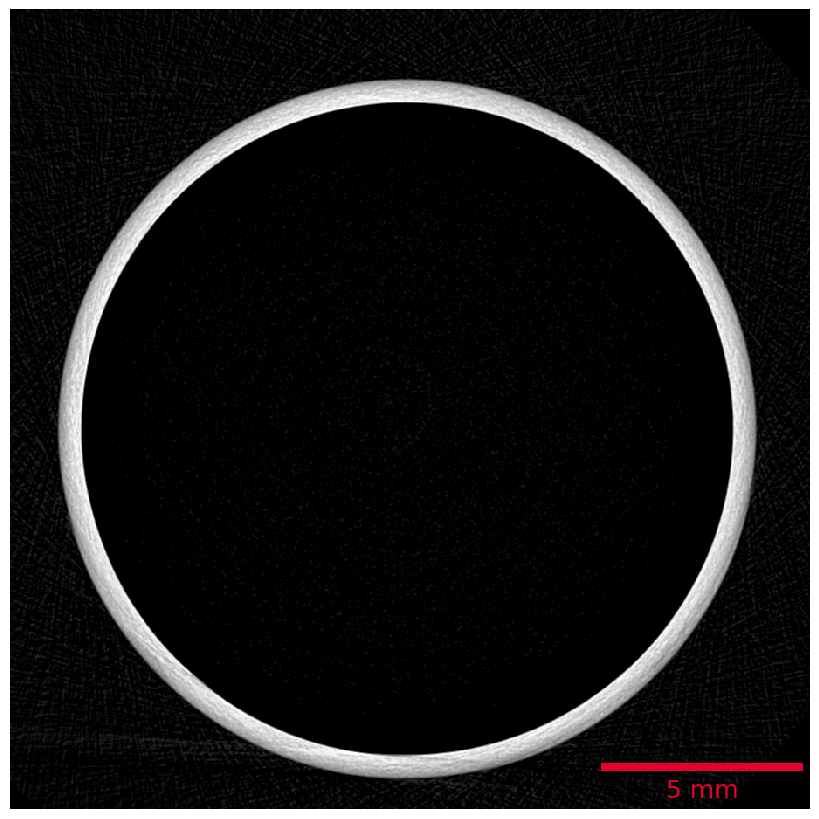

Done


In [24]:
# Let's write the output image with the chosen width (and scaled height)
# Scale the output figure size exactly: https://stackoverflow.com/a/13714720/323100
# Write canvas containts to image: https://stackoverflow.com/a/14913405/323100
for c, reconstruction in enumerate(Reconstructions[numpy.round(numpy.linspace(0, len(Reconstructions) - 1, NumberOfFrames)).astype(int)]):
    # Generate a figure with the chosen width and accordingly scaled height
    fig = plt.figure(figsize=(WidthOfOutput / plt.rcParams['figure.dpi'],
                              round(WidthOfOutput * (reconstruction.shape[0] / reconstruction.shape[1])) / plt.rcParams['figure.dpi']),
                     dpi=plt.rcParams['figure.dpi'])
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    # Equalize histogram for display reasons
    # Rotate reconstruction for display reasons
    ax.imshow(skimage.exposure.equalize_adapthist(dask.array.rot90(reconstruction)))
    ax.add_artist(ScaleBar(Pixelsize, 'um', fixed_value=5, fixed_units='mm'))
    s = '_'
    fig.canvas.print_jpg(os.path.join(BaseFolder, Sample, 'mov', 'mov_rec',
                                      s.join([Sample,
                                              str(NumberOfFrames),
                                              'projections',
                                              'of',
                                              str(len(Projections)),
                                              str(WidthOfOutput),
                                              'px',
                                              '%03d.jpg' % c])))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.show()
print('Done')

In [25]:
print('Now you can copy the files from %s to "TalkFolder/movies/scan/projection"' % os.path.join(BaseFolder, Sample, 'mov', 'mov_proj'))

Now you can copy the files from /media/habi/Fast_SSD/DKF Lung-Metastasis/Overview/KP-TNIKWT02/mov/mov_proj to "TalkFolder/movies/scan/projection"


In [26]:
print('Now you can copy the files from %s to "TalkFolder/movies/scan/reconstruction"' % os.path.join(BaseFolder, Sample, 'mov', 'mov_rec'))

Now you can copy the files from /media/habi/Fast_SSD/DKF Lung-Metastasis/Overview/KP-TNIKWT02/mov/mov_rec to "TalkFolder/movies/scan/reconstruction"


In [52]:
Projections.shape[1]//2

410.0

(-0.5, 1223.5, 939.5, -0.5)

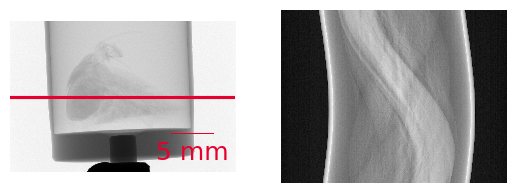

In [53]:
height = Projections.shape[1]//2
# Show Sinogram
plt.subplot(121)
plt.imshow(Projections[0])
plt.axhline(height, c='#E6002E')
plt.gca().add_artist(ScaleBar(Pixelsize, 'um'))
plt.axis('off')
plt.subplot(122)
plt.imshow(Projections[:,height,:], cmap='gray_r')
plt.axis('off')

In [28]:
from skimage.transform import radon, rescale

In [63]:
skimage.transform.iradon(Projections[:,height,:], filter_name='ramp')

AttributeError: 'Array' object has no attribute 'flags'

In [58]:
skimage.transform.radon_transform?

Type:        module
String form: <module 'skimage.transform.radon_transform' from '/home/habi/miniconda3/envs/uct_lecture/lib/python3.11/site-packages/skimage/transform/radon_transform.py'>
File:        ~/miniconda3/envs/uct_lecture/lib/python3.11/site-packages/skimage/transform/radon_transform.py
Docstring:   <no docstring>